In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

In [2]:
convert_factor = 0.3894e-27 / 1e-18  # 1 / eV^2 -> cm^2
mn_ev = 1e9 # neutron mass, eV

def get_fifth_force_sigma_n(mx, mphi, lim='fifth_force', yx_lim='SIDM', Nx=1):
    # Input mx in eV (array-like)
    dat = None
    if lim == 'fifth_force':
        dat = fifth_force_lim
    elif lim == 'n_xe':
        dat = n_xe_lim
    elif lim == 'stellar_cooling':
        dat = stellar_cooling_lim
    elif lim == 'sn1987a':
        dat = sn1987a_lim
        
    yn   = 10**np.interp(np.log10(mphi), np.log10(dat[0]), np.log10(dat[1]), right=np.nan)

    if yx_lim == 'SIDM':
        yx = 10**np.interp(np.log10(mx), np.log10(sidm_yx_lim[0]), np.log10(sidm_yx_lim[1]))
    elif yx_lim == 'unity':
        yx = 1
    elif yx_lim == 'root4pi':
        yx = np.sqrt(4 * np.pi)
    
    mu_xn = mx * mn_ev / (mx + mn_ev)

    # Cross section in cm^2
#     sig_n = convert_factor * yn**2 * yx**2 * mu_xn**2 / (4 * np.pi * (mphi**2 + (1e-3 * mx)**2)**2)
#     sig_n = convert_factor * Nx**2 * yn**2 * yx**2 * mu_xn**2 / (4 * np.pi * (mphi**2 + (1e-3 * mn_eV)**2)**2)
    sig_n = convert_factor * Nx**2 * yn**2 * yx**2 * mu_xn**2 / (4 * np.pi * (mphi**2 + (1e-3 * mu_xn)**2)**2)
    
    return sig_n

## Existing limits

Fifth-force limits

In [3]:
fifth_force_lim = np.genfromtxt('./fifth_force_lim_yn.csv', delimiter=',').T
n_xe_lim = np.genfromtxt('./n_xe_yn_lim.csv', delimiter=',').T
stellar_cooling_lim = np.genfromtxt('./stellar_cooling_yn_lim.csv', delimiter=',').T
sn1987a_lim = np.genfromtxt('./sn1987a_yn_lim_lower.csv', delimiter=',').T

# DM mass in MeV
sidm_yx_lim     = np.genfromtxt('./sidm_yx_lim.csv', delimiter=',').T
sidm_yx_lim[0]  = sidm_yx_lim[0] * 1e6  # Convert MeV to eV

Direct detection limits using the approximate formula in the composite DM paper.

In [4]:
c = 3e5
c_cm = 3e10  # cm/s
v0 = 220 / c
mN = 1
q0 = v0 * 1

sub_component_frac = 1

def get_dm_xsec(mX, mchi, Eth, mN, nevts, target_mass, expos):
    """
    Approximate cross section limits for direct detection experiments
    
    Parameters:
    mX: DM mass in GeV
    mchi: DM constituent mass in GeV
    Eth: energy threshold in GeV
    mN: *nucleus* mass in GeV
    nevts: number of events to set the 95% CL limits
    target_mass: kg
    expos: exposure in seconds
    """
    
    A = 1.0 * mN ## number of nucleons
    mnuc = 1

    gtgx = 1
    rhoX = 0.3 * sub_component_frac ## GeV/cm^3

    NX = mX/mchi
    mu = (mX * mN)/(mX + mN)
    
    Rx = (9*np.pi/4 * mX/mchi**4)**(1/3)
    sig0 = NX**2 * gtgx**2 * mu**2

    nT = (target_mass * 1e3) / A * 6.02e23
    sigtot_lim = (nevts / (nT * expos)) / ( rhoX/mX * v0 * c_cm) # in cm^2

    ### Below is incorrect
    # sigXn12 = sigtot_lim * (8 * Eth * v0**2 * mnuc**3) / (A * q0**4)
    # sigXn3 = sigtot_lim * (64 * A * Rx**4 * v0**2 * mnuc**5 * Eth**3)/(3 * q0**4)
    # sigXtot = 1.0*sigXn12

    # gidx3 = mX > np.sqrt(2) * mchi/(9*np.pi) * (mchi**2/(mN * Eth))**(3/2)
    # sigXtot[gidx3] = sigXn3[gidx3]
    
    ### My implementation
    q_min = np.sqrt(2 * A * mnuc * Eth)
    q_max = np.min([2*mX*v0, 2*np.full_like(mX, mN)*v0], axis=0)
    
    mu_chi_n = (mX * mnuc) / (mX + mnuc)
    sigXtot = sigtot_lim * 4 * v0**2 * mu_chi_n**2 / ( A**2 * q0**4 * (1/(q_min**2) - 1/(q_max**2)) )
    sigXn3 = sigtot_lim * 8 * Rx**4 * v0**2 * mu_chi_n**2 / (3 * A**2 * q0**4 * (1/(q_min**6) - 1/(q_max**6)) )

    gidx3 = mX > np.sqrt(2) * mchi/(9*np.pi) * (mchi**2/(mN * Eth))**(3/2)
    sigXtot[gidx3] = sigXn3[gidx3]

    # When `q_min` > `q_max` will become negative
    # That means the maximum momentum transfer is below the detectable threshold
    sigXtot[sigXtot < 0] = np.nan
    
    return sigXtot

Let us try to reproduce the limits in Fig. 5 of the composite DM paper.

In [5]:
mX = np.logspace(2, 17, 1000)
mchi = 10
cdmslite_limit = get_dm_xsec(mX, mchi, 500e-9, 73, 10, 0.2, np.pi * 1e7)
xenon_limit = get_dm_xsec(mX, mchi, 5000e-9, 131, 3, 1000, np.pi * 1e7)

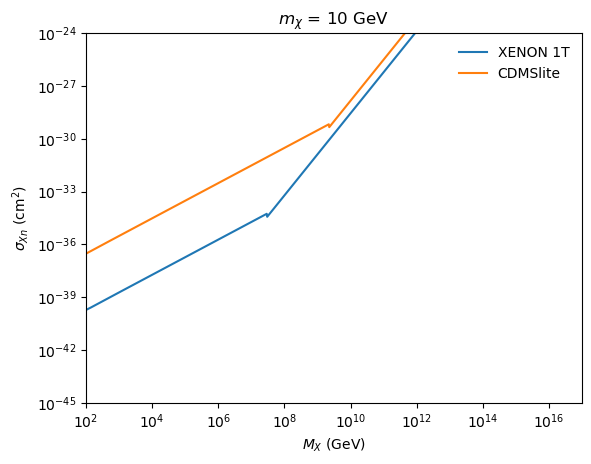

In [6]:
plt.loglog(mX, xenon_limit, label='XENON 1T')
plt.loglog(mX, cdmslite_limit, label='CDMSlite')

plt.xlim(1e2, 1e17)
plt.ylim(1e-45, 1e-24)

plt.title('$m_\chi$ = 10 GeV')
plt.xlabel('$M_X$ (GeV)')
plt.ylabel('$\sigma_{Xn}$ (cm$^2$)')
plt.legend(frameon=False)

Now check the case of lower mass. Expect to see a cutoff in DM mass set by the energy threshold.

In [7]:
mX = np.logspace(-2, 5, 1000)
mchi = 1e-3
cdmslite_limit = get_dm_xsec(mX, mchi, 500e-9, 73, 10, 0.2, np.pi * 1e7)
xenon_limit = get_dm_xsec(mX, mchi, 5000e-9, 131, 3, 1000, np.pi * 1e7)

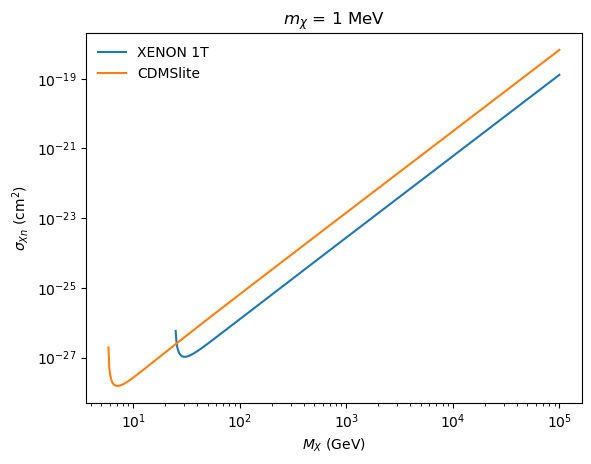

In [8]:
plt.loglog(mX, xenon_limit, label='XENON 1T')
plt.loglog(mX, cdmslite_limit, label='CDMSlite')

plt.title('$m_\chi$ = 1 MeV')
plt.xlabel('$M_X$ (GeV)')
plt.ylabel('$\sigma_{Xn}$ (cm$^2$)')
plt.legend(frameon=False)

In [9]:
convert_factor = 0.3894e-27 / 1e-18  # 1 / eV^2 -> cm^2
mn_ev = 1e9                          # neutron mass, eV

def get_sphere_sigma_n(mx, mphi, yn, yx_lim='unity', yx=None):    
    # Input mx in eV (array-like)
    # Note that we parametrize the cross section in a way slightly
    # different from the composite dm paper
    # -- there is a (small) factor of mediator mass squared
    # -- reference momentum transfer is chosen as v_dm * mn

    sig_n = np.empty_like(mx)
    if yx_lim == 'unity':
        yx = 1
    else:
        raise('Other ychi choices not implemented')
        
    mu_xn = mx * mn_ev / (mx + mn_ev)

    # Cross section in cm^2
    # sig_n = convert_factor * yn**2 * yx**2 * mu_xn**2 / (4 * np.pi * (mphi**2 + (1e-3 * mx)**2)**2)
    # sig_n = convert_factor * yn**2 * yx**2 * mu_xn**2 / (4 * np.pi * (mphi**2 + (1e-3 * mn_ev)**2)**2)
    sig_n = convert_factor * yn**2 * yx**2 * mu_xn**2 / (4 * np.pi * (mphi**2 + (1e-3 * mu_xn)**2)**2)


    return sig_n

Text(0, 0.5, 'Single neucleon coupling $y_n$')

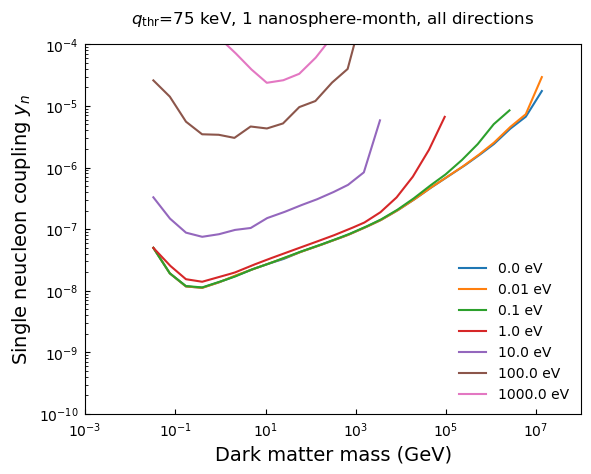

In [10]:
alpha_file = np.load('alpha_n_75kev_1spheremonth_alldirs.npz', allow_pickle='True')

mphi = alpha_file['mediator_mass']
mx_gev = alpha_file['mx_gev']
alpha_lim = alpha_file['alpha_n_lim']

yn_limit = alpha_lim * 4 * np.pi / 2

# Plot the yn limits
fig, ax = plt.subplots()

for i, lim in enumerate(yn_limit):
    ax.loglog(mx_gev[i], lim, label=f'{mphi[i]} eV')

ax.set_xlim(1e-3, 1e8)
ax.set_ylim(1e-10, 1e-4)
ax.tick_params(axis='both', which='both', direction="in", pad=5)

ax.set_title(r'$q_{\mathrm{thr}}$=75 keV, 1 nanosphere-month, all directions', fontsize=12, pad=15)
ax.legend(frameon=False, fontsize=10)
ax.set_xlabel('Dark matter mass (GeV)', fontsize=14)
ax.set_ylabel(r'Single neucleon coupling $y_n$', fontsize=14)

In [11]:
usphere_alpha_n_1ev_lim = np.genfromtxt('./microsphere_an_lim_2020_1ev.csv', delimiter=',').T

usphere_gev = usphere_alpha_n_1ev_lim[0]
usphere_yn_limit_1ev =  usphere_alpha_n_1ev_lim[1] * 4 * np.pi / 2

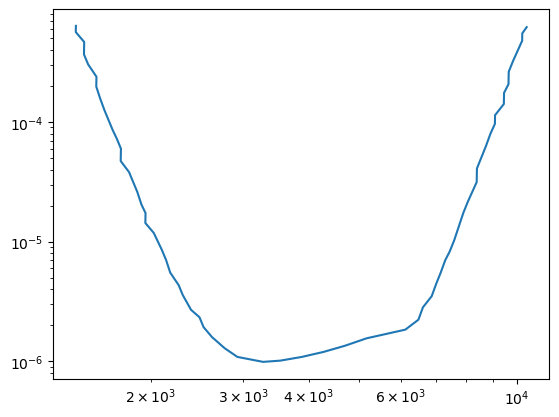

In [12]:
plt.loglog(usphere_gev, usphere_yn_limit_1ev)

## The SIDM limits for large DM mass is incorrect at this point - this plot is incorrect!

/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_13481/1423727573.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap


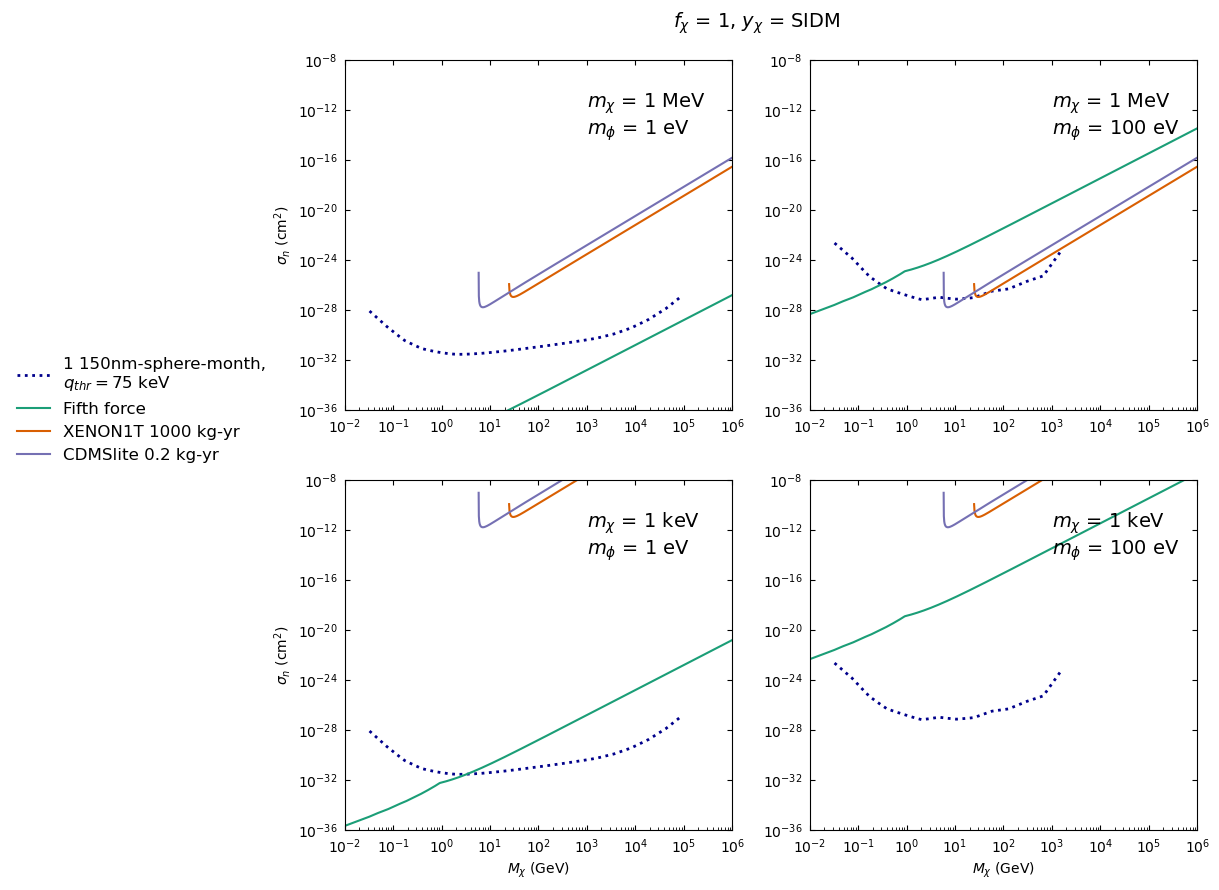

In [13]:
mmx1 = 1e6     # DM constituent mass in eV
mmx2 = 1e3     # DM constituent mass in eV
mx_ev = mx_gev * 1e9

fig, ax = plt.subplots(2, 2, figsize=(11, 10))

name = "Dark2"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list
for a in ax.flatten():
    a.set_prop_cycle(color=colors)

mx_plot = np.logspace(7, 15, 2000)
nx_plot1 = mx_plot / mmx1
nx_plot2 = mx_plot / mmx2

# 1 eV mediator
i = 3

# 1 MeV constituent
ax[0, 0].loglog(mx_gev[i], get_sphere_sigma_n(mx_ev[i], mphi[i], yn_limit[i]), 
                linestyle=':', linewidth=2, color='darkblue',
                label='1 150nm-sphere-month, \n$q_{{thr}}=75 \  \mathrm{keV}$')
ax[0, 0].loglog(mx_plot/1e9, get_fifth_force_sigma_n(mx_plot, mphi[i], lim='fifth_force', yx_lim='SIDM', Nx=nx_plot1), label='Fifth force')
ax[0, 0].text(1e3, 1e-14, f'$m_\chi$ = 1 MeV\n$m_\phi$ = {int(mphi[i])} eV', fontsize=14)

# m_x = 1 keV
ax[1, 0].loglog(mx_gev[i], get_sphere_sigma_n(mx_ev[i], mphi[i], yn_limit[i]),
                linestyle=':', linewidth=2, color='darkblue',)
ax[1, 0].loglog(mx_plot/1e9, get_fifth_force_sigma_n(mx_plot, mphi[i], lim='fifth_force', yx_lim='SIDM', Nx=nx_plot2))
ax[1, 0].text(1e3, 1e-14, f'$m_\chi$ = 1 keV\n$m_\phi$ = {int(mphi[i])} eV', fontsize=14)

# 1 keV constituent
i = 5
ax[0, 1].loglog(mx_gev[i], get_sphere_sigma_n(mx_ev[i], mphi[i], yn_limit[i]),
                linestyle=':', linewidth=2, color='darkblue',)
ax[0, 1].loglog(mx_plot/1e9, get_fifth_force_sigma_n(mx_plot, mphi[i], lim='fifth_force', yx_lim='SIDM', Nx=nx_plot1))
ax[0, 1].text(1e3, 1e-14, f'$m_\chi$ = 1 MeV\n$m_\phi$ = {int(mphi[i])} eV', fontsize=14)

ax[1, 1].loglog(mx_gev[i], get_sphere_sigma_n(mx_ev[i], mphi[i], yn_limit[i]),
                linestyle=':', linewidth=2, color='darkblue')
ax[1, 1].loglog(mx_plot/1e9, get_fifth_force_sigma_n(mx_plot, mphi[i], lim='fifth_force', yx_lim='SIDM', Nx=nx_plot2))
ax[1, 1].text(1e3, 1e-14, f'$m_\chi$ = 1 keV\n$m_\phi$ = {int(mphi[i])} eV', fontsize=14)

for a in ax[1]:
    a.set_xlabel('$M_\chi$ (GeV)')
for a in [ax[0, 0], ax[1, 0]]:
    a.set_ylabel('$\sigma_n$ ($\mathrm{cm}^2$)')
    
for a in ax[0]:
    a.loglog(mx_plot/1e9, get_dm_xsec(mx_plot/1e9, mmx1/1e9, 5000e-9, 130, 3, 1000, np.pi * 1e7), label='XENON1T 1000 kg-yr')
    a.loglog(mx_plot/1e9, get_dm_xsec(mx_plot/1e9, mmx1/1e9, 500e-9, 73, 10, 0.2, np.pi * 1e7), label='CDMSlite 0.2 kg-yr')
for a in ax[1]:
    a.loglog(mx_plot/1e9, get_dm_xsec(mx_plot/1e9, mmx2/1e9, 5000e-9, 130, 3, 1000, np.pi * 1e7), label='XENON1T 1000 kg-yr')
    a.loglog(mx_plot/1e9, get_dm_xsec(mx_plot/1e9, mmx2/1e9, 500e-9, 73, 10, 0.2, np.pi * 1e7), label='CDMSlite 0.2 kg-yr')

for a in ax.flatten():
    a.set_xlim(1e-2, 1e6)
    a.tick_params(right=True, top=True, labelright=False, labeltop=False, labelrotation=0)
    a.tick_params(axis='both', which='both', direction="in", pad=5)

fig.suptitle('$f_\chi$ = 1, $y_\chi$ = SIDM', x=0.5, y=0.93, fontsize=14)

for a in [ax[0, 0], ax[1, 0]]:
    a.set_ylim(1e-36, 1e-8)
for a in [ax[0, 1], ax[1, 1]]:
    a.set_ylim(1e-36, 1e-8)
    
ax[0, 0].legend(frameon=False, loc='center right', bbox_to_anchor=(-0.15, 0), fontsize=12)

Now do the case $f_\chi = 0.05$

Text(0, 0.5, 'Single neucleon coupling $y_n$')

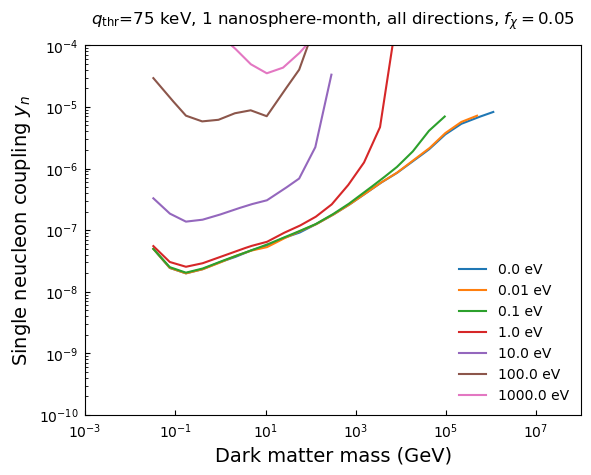

In [14]:
alpha_file = np.load('alpha_n_75kev_1spheremonth_alldirs_fchi_0_05.npz', allow_pickle='True')

mphi = alpha_file['mediator_mass']
mx_gev = alpha_file['mx_gev']
alpha_lim = alpha_file['alpha_n_lim']

yn_limit = alpha_lim * 4 * np.pi / 2

# Plot the yn limits
fig, ax = plt.subplots()

for i, lim in enumerate(yn_limit):
    ax.loglog(mx_gev[i], lim, label=f'{mphi[i]} eV')

ax.set_xlim(1e-3, 1e8)
ax.set_ylim(1e-10, 1e-4)
ax.tick_params(axis='both', which='both', direction="in", pad=5)

ax.set_title(r'$q_{\mathrm{thr}}$=75 keV, 1 nanosphere-month, all directions, $f_\chi=0.05$', fontsize=12, pad=15)
ax.legend(frameon=False, fontsize=10)
ax.set_xlabel('Dark matter mass (GeV)', fontsize=14)
ax.set_ylabel(r'Single neucleon coupling $y_n$', fontsize=14)

/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_13481/2308503839.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap


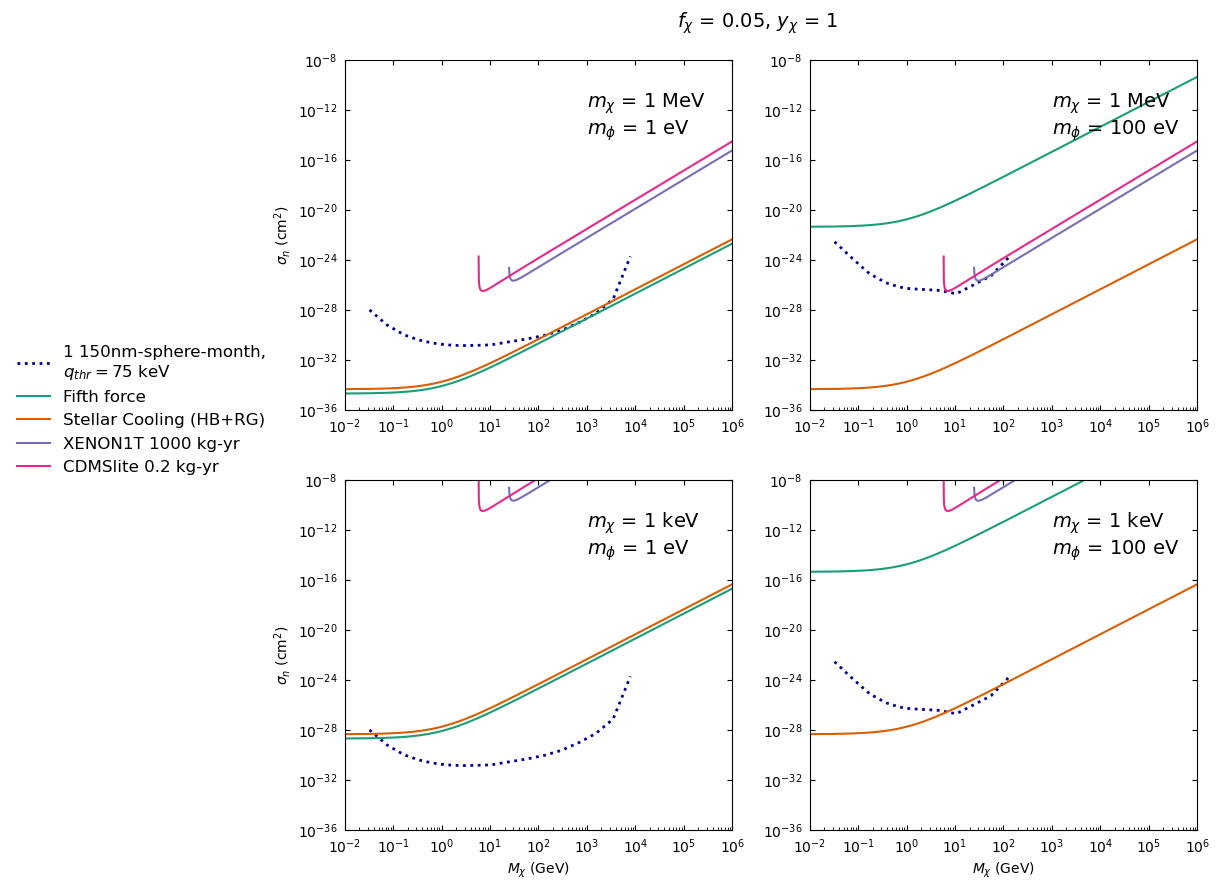

In [15]:
mmx1 = 1e6     # DM constituent mass in eV
mmx2 = 1e3     # DM constituent mass in eV
mx_ev = mx_gev * 1e9

fig, ax = plt.subplots(2, 2, figsize=(11, 10))

name = "Dark2"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list
for a in ax.flatten():
    a.set_prop_cycle(color=colors)

mx_plot = np.logspace(7, 15, 2000)
nx_plot1 = mx_plot / mmx1
nx_plot2 = mx_plot / mmx2

# 1 eV mediator
i = 3

# 1 MeV constituent
ax[0, 0].loglog(mx_gev[i], get_sphere_sigma_n(mx_ev[i], mphi[i], yn_limit[i]), 
                linestyle=':', linewidth=2, color='darkblue',
                label='1 150nm-sphere-month, \n$q_{{thr}}=75 \  \mathrm{keV}$')
ax[0, 0].loglog(mx_plot/1e9, get_fifth_force_sigma_n(mx_plot, mphi[i], lim='fifth_force', yx_lim='unity', Nx=nx_plot1), label='Fifth force')
ax[0, 0].loglog(mx_plot/1e9, get_fifth_force_sigma_n(mx_plot, mphi[i], 'stellar_cooling', 'unity', nx_plot1), '-', label='Stellar Cooling (HB+RG)')
ax[0, 0].text(1e3, 1e-14, f'$m_\chi$ = 1 MeV\n$m_\phi$ = {int(mphi[i])} eV', fontsize=14)

# m_x = 1 keV
ax[1, 0].loglog(mx_gev[i], get_sphere_sigma_n(mx_ev[i], mphi[i], yn_limit[i]),
                linestyle=':', linewidth=2, color='darkblue',)
ax[1, 0].loglog(mx_plot/1e9, get_fifth_force_sigma_n(mx_plot, mphi[i], lim='fifth_force', yx_lim='unity', Nx=nx_plot2))
ax[1, 0].loglog(mx_plot/1e9, get_fifth_force_sigma_n(mx_plot, mphi[i], 'stellar_cooling', 'unity', nx_plot2), '-')
ax[1, 0].text(1e3, 1e-14, f'$m_\chi$ = 1 keV\n$m_\phi$ = {int(mphi[i])} eV', fontsize=14)

# 1 keV constituent
i = 5
ax[0, 1].loglog(mx_gev[i], get_sphere_sigma_n(mx_ev[i], mphi[i], yn_limit[i]),
                linestyle=':', linewidth=2, color='darkblue',)
ax[0, 1].loglog(mx_plot/1e9, get_fifth_force_sigma_n(mx_plot, mphi[i], lim='fifth_force', yx_lim='unity', Nx=nx_plot1))
ax[0, 1].loglog(mx_plot/1e9, get_fifth_force_sigma_n(mx_plot, mphi[i], 'stellar_cooling', 'unity', nx_plot1), '-')
ax[0, 1].text(1e3, 1e-14, f'$m_\chi$ = 1 MeV\n$m_\phi$ = {int(mphi[i])} eV', fontsize=14)

ax[1, 1].loglog(mx_gev[i], get_sphere_sigma_n(mx_ev[i], mphi[i], yn_limit[i]),
                linestyle=':', linewidth=2, color='darkblue')
ax[1, 1].loglog(mx_plot/1e9, get_fifth_force_sigma_n(mx_plot, mphi[i], lim='fifth_force', yx_lim='unity', Nx=nx_plot2))
ax[1, 1].loglog(mx_plot/1e9, get_fifth_force_sigma_n(mx_plot, mphi[i], 'stellar_cooling', 'unity', nx_plot2), '-')
ax[1, 1].text(1e3, 1e-14, f'$m_\chi$ = 1 keV\n$m_\phi$ = {int(mphi[i])} eV', fontsize=14)

for a in ax[1]:
    a.set_xlabel('$M_\chi$ (GeV)')
for a in [ax[0, 0], ax[1, 0]]:
    a.set_ylabel('$\sigma_n$ ($\mathrm{cm}^2$)')
    
for a in ax[0]:
    a.loglog(mx_plot/1e9, get_dm_xsec(mx_plot/1e9, mmx1/1e9, 5000e-9, 130, 3/0.05, 1000, np.pi * 1e7), label='XENON1T 1000 kg-yr')
    a.loglog(mx_plot/1e9, get_dm_xsec(mx_plot/1e9, mmx1/1e9, 500e-9, 73, 10/0.05, 0.2, np.pi * 1e7), label='CDMSlite 0.2 kg-yr')
for a in ax[1]:
    a.loglog(mx_plot/1e9, get_dm_xsec(mx_plot/1e9, mmx2/1e9, 5000e-9, 130, 3/0.05, 1000, np.pi * 1e7), label='XENON1T 1000 kg-yr')
    a.loglog(mx_plot/1e9, get_dm_xsec(mx_plot/1e9, mmx2/1e9, 500e-9, 73, 10/0.05, 0.2, np.pi * 1e7), label='CDMSlite 0.2 kg-yr')

for a in ax.flatten():
    a.set_xlim(1e-2, 1e6)
    a.tick_params(right=True, top=True, labelright=False, labeltop=False, labelrotation=0)
    a.tick_params(axis='both', which='both', direction="in", pad=5)

fig.suptitle('$f_\chi$ = 0.05, $y_\chi$ = 1', x=0.5, y=0.93, fontsize=14)

for a in [ax[0, 0], ax[1, 0]]:
    a.set_ylim(1e-36, 1e-8)
for a in [ax[0, 1], ax[1, 1]]:
    a.set_ylim(1e-36, 1e-8)
    
ax[0, 0].legend(frameon=False, loc='center right', bbox_to_anchor=(-0.15, 0), fontsize=12)

In [16]:
yale_colors = ['#00356b', '#286dc0', '#63aaff', '#4a4a4a']

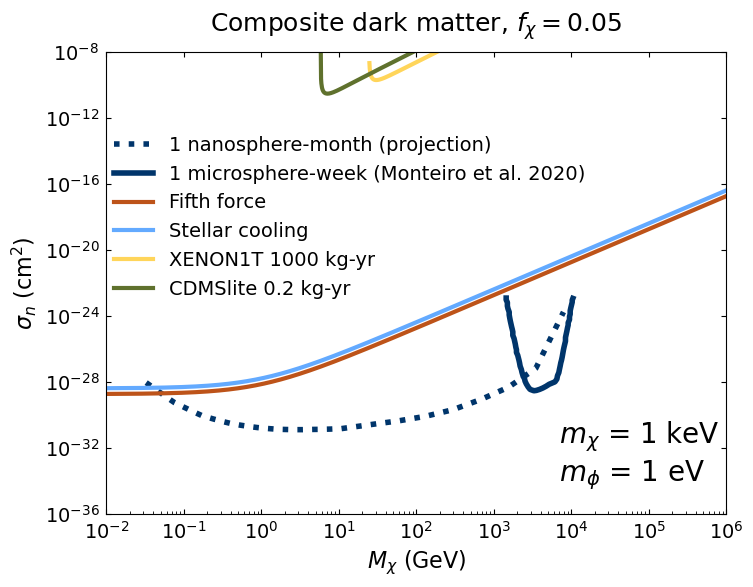

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# name = "Dark2"
# cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
# colors = cmap.colors  # type: list
# ax.set_prop_cycle(color=colors)
colors=['#bd5319', '#63aaff', '#ffd55a', '#5f712d', ]
ax.set_prop_cycle(color=colors)

# plt.loglog(usphere_gev, usphere_yn_limit_1ev)

i = 3
ax.loglog(mx_gev[i], get_sphere_sigma_n(mx_ev[i], mphi[i], yn_limit[i]),
          linestyle=':', linewidth=4, color=yale_colors[0], label='1 nanosphere-month (projection)')
ax.loglog(usphere_gev, get_sphere_sigma_n(usphere_gev*1e9, mphi[i], usphere_yn_limit_1ev),
          linestyle='-', linewidth=4, color=yale_colors[0], label='1 microsphere-week (Monteiro et al. 2020)')
ax.loglog(mx_plot/1e9, get_fifth_force_sigma_n(mx_plot, mphi[i], lim='fifth_force', yx_lim='unity', Nx=nx_plot2), linewidth=3, label='Fifth force')
ax.loglog(mx_plot/1e9, get_fifth_force_sigma_n(mx_plot, mphi[i], 'stellar_cooling', 'unity', nx_plot2), '-', linewidth=3, label='Stellar cooling')
ax.loglog(mx_plot/1e9, get_dm_xsec(mx_plot/1e9, mmx2/1e9, 5000e-9, 130, 3/0.05, 1000, np.pi * 1e7), label='XENON1T 1000 kg-yr', linewidth=3)
ax.loglog(mx_plot/1e9, get_dm_xsec(mx_plot/1e9, mmx2/1e9, 500e-9, 73, 10/0.05, 0.2, np.pi * 1e7), label='CDMSlite 0.2 kg-yr', linewidth=3)

ax.text(7e3, 1e-34, f'$m_\chi$ = 1 keV\n$m_\phi$ = {int(mphi[i])} eV', fontsize=20)
# ax.text(1e-1, 1e-35, 'PRELIMINARY', color='lightgrey', rotation=-45, fontsize=60, alpha=0.3)
ax.set_xlabel('$M_\chi$ (GeV)', fontsize=16)
ax.set_ylabel('$\sigma_n$ ($\mathrm{cm}^2$)', fontsize=16)

ax.set_title('Composite dark matter, $f_\chi = 0.05$', fontsize=18, pad=15)
ax.set_xlim(1e-2, 1e6)
ax.set_ylim(1e-36, 1e-8)
ax.tick_params(right=True, top=True, labelright=False, labeltop=False, labelrotation=0)
ax.tick_params(axis='both', which='both', direction="in", pad=5, labelsize=14)
ax.legend(frameon=False, fontsize=14, loc=(0, 0.45))


plt.savefig('/Users/yuhan/work/nanospheres/figures/nanosphere_compdm_projection.png', format='png', transparent=True, dpi=400)

## Next: calculate the case of an array with better sensitivity